<a href="https://www.kaggle.com/noormohammadkwaja/kwaja12345?scriptVersionId=82941205" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
import os
from glob import glob
import matplotlib.pyplot as plt
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import zlib
import itertools
import sklearn
import itertools
import scipy
import skimage
from skimage.transform import resize
import csv
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split,learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import keras
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda,MaxPool2D, BatchNormalization
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight
from keras.models import Sequential, model_from_json
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D,MaxPool2D,MaxPooling2D,AvgPool2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from imblearn.over_sampling import RandomOverSampler

In [3]:
imageSize=227
train_dir = "../input/kermany2018/oct2017/OCT2017 /train/"
test_dir = "../input/kermany2018/oct2017/OCT2017 /test/"
# ['DME', 'CNV', 'NORMAL', '.DS_Store', 'DRUSEN']
from tqdm import tqdm
def get_data(folder):
    """
        Load the data and labels from the given folder.
    """
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['CNV']:
                label = 1
            elif folderName in ['DME']:
                label = 2
            elif folderName in ['DRUSEN']:
                label = 3
            else:
                label = 4
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y
#X_train, y_train = get_data(train_dir) # Un-comment to use full dataset: Step 1 of 2
X_test, y_test= get_data(test_dir)

100%|██████████| 243/243 [00:13<00:00, 18.27it/s]


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_test, y_test, test_size=0.2) 
# Re-comment touse full dataset
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 4)
y_testHot = to_categorical(y_test, num_classes = 4)
print("The size of X_train is: {}".format(X_train.shape))
print("The size of y_train is: {}".format(y_train.shape))
print("The size of X_test is: {}".format(X_test.shape))
print("The size of y_test is: {}".format(y_test.shape))
X_train = X_train.reshape(X_train.shape[0], 227, 227, 3)
X_test = X_test.reshape(X_test.shape[0], 227, 227, 3)
X_train=X_train/255.0
X_test=X_test/255.0


The size of X_train is: (774, 227, 227, 3)
The size of y_train is: (774,)
The size of X_test is: (194, 227, 227, 3)
The size of y_test is: (194,)


In [6]:
# (3) Create a sequential model
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(227,227,3), kernel_size=(11,11),\
 strides=(4,4), padding='valid'))
model.add(Activation('relu'))
# Pooling 
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation before passing it to the next layer
model.add(BatchNormalization())

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation
model.add(BatchNormalization())

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation
model.add(BatchNormalization())

# Passing it to a dense layer
model.add(Flatten())
# 1st Dense Layer
model.add(Dense(4096, input_shape=(224*224*3,)))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())

# 2nd Dense Layer
model.add(Dense(4096))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())

# 3rd Dense Layer
model.add(Dense(1000))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())

# Output Layer
model.add(Dense(17))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
activation_9 (Activation)    (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_10 (Activation)   (None, 17, 17, 256)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 256)        

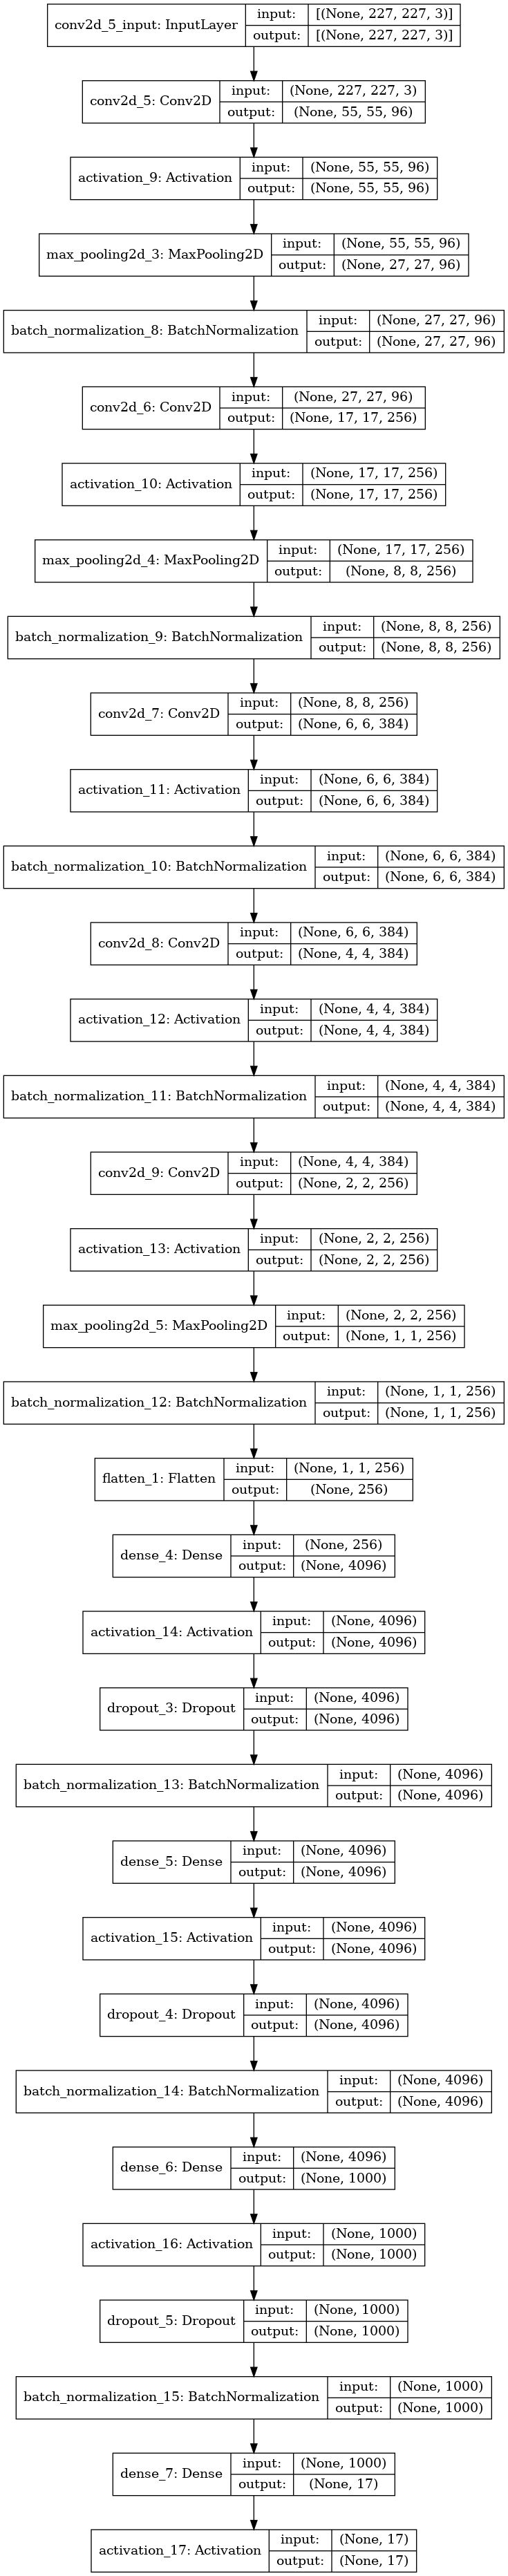

In [7]:
import tensorflow as tf
tf.keras.utils.plot_model(model, './alex_model.png', show_shapes = True)

In [8]:
model.compile(loss='sparse_categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])

In [41]:
datagen=ImageDataGenerator(featurewise_center=False,
samplewise_center=False,
featurewise_std_normalization=False,
zca_whitening=False,
rotation_range=1,
zoom_range=0.1,
width_shift_range=0.2,
height_shift_range=0.2,
horizontal_flip=False,
vertical_flip=False)
datagen.fit(X_train)
hist=model.fit_generator(datagen.flow(X_train,y_train,batch_size=20),epochs=50,verbose=1,validation_data=(X_test,y_test))
score=model.evaluate(X_test,y_test)
print('test loss:',score[0])
print('test accuracy:',score[1])

Epoch 1/50
39/39 [==============================] - 8s 189ms/step - loss: 0.4317 - accuracy: 0.8398 - val_loss: 1.1945 - val_accuracy: 0.7113
Epoch 2/50
39/39 [==============================] - 8s 198ms/step - loss: 0.3890 - accuracy: 0.8747 - val_loss: 1.0281 - val_accuracy: 0.7526
Epoch 3/50
39/39 [==============================] - 8s 210ms/step - loss: 0.3023 - accuracy: 0.9070 - val_loss: 0.4870 - val_accuracy: 0.8093
Epoch 4/50
39/39 [==============================] - 8s 196ms/step - loss: 0.3022 - accuracy: 0.9018 - val_loss: 0.2596 - val_accuracy: 0.8866
Epoch 5/50
39/39 [==============================] - 7s 191ms/step - loss: 0.3450 - accuracy: 0.8915 - val_loss: 1.0409 - val_accuracy: 0.7680
Epoch 6/50
39/39 [==============================] - 8s 200ms/step - loss: 0.2894 - accuracy: 0.9057 - val_loss: 0.2190 - val_accuracy: 0.9227
Epoch 7/50
39/39 [==============================] - 8s 213ms/step - loss: 0.2960 - accuracy: 0.8915 - val_loss: 0.2053 - val_accuracy: 0.9278
Epoch 

In [42]:
val_acc=hist.history['val_accuracy']
acc=hist.history['accuracy']
val_loss=hist.history['val_loss']
loss=hist.history['loss']

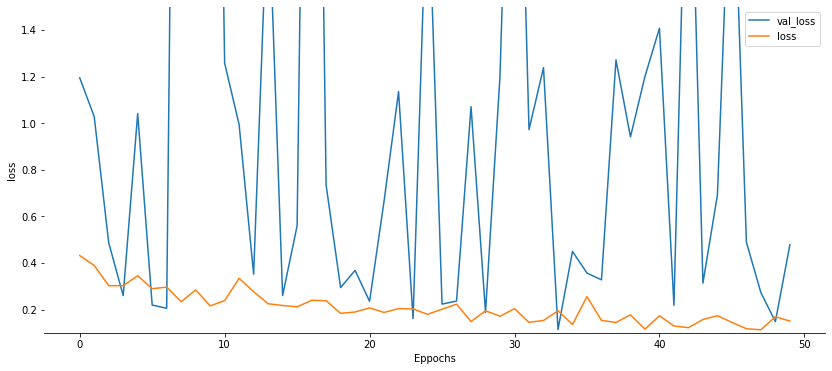

In [43]:
fig=plt.figure(figsize=(14,6))
plt.plot(np.arange(len(val_loss)),val_loss,label='val_loss')
plt.plot(np.arange(len(loss)),loss,label='loss')
plt.ylim(0.1,1.5)
plt.xlabel("Eppochs")
plt.ylabel("loss")
plt.legend()
sns.despine(left=True)
plt.show()

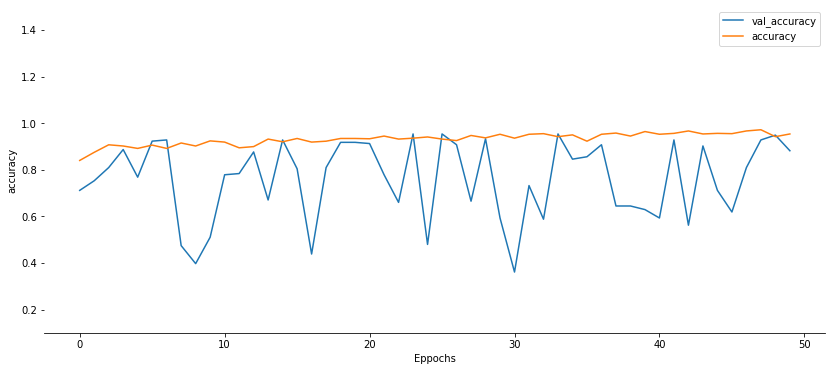

In [44]:
fig=plt.figure(figsize=(14,6))
plt.plot(np.arange(len(val_acc)),val_acc,label='val_accuracy')
plt.plot(np.arange(len(acc)),acc,label='accuracy')
plt.ylim(0.1,1.5)
plt.xlabel("Eppochs")
plt.ylabel("accuracy")
plt.legend()
sns.despine(left=True)
plt.show()

In [45]:
pred=model.predict(X_test,batch_size=10)

In [46]:
prd=[]
for i in range(len(pred)):
    prd.append(np.argmax(pred.round()[i]))
conf=pd.DataFrame(confusion_matrix(y_test,prd))

In [47]:
print('\nConfusion Matrix ')
conf


Confusion Matrix 


,0,1,2,3
0,45,0,0,0
1,2,47,1,4
2,11,2,30,0
3,3,0,0,49


In [20]:
import seaborn
cm = confusion_matrix(y_test, prd)
plt.figure(figsize = (12,12))
ax = seaborn.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels = label, yticklabels=label)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

NameError: name 'label' is not defined

<Figure size 864x864 with 0 Axes>

In [39]:
from keras.models import load_model
model.save("oct_alex.h5")

In [48]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=227):
  #"""Reads an image from filename, turns it into a tensor and reshapes it to (img_shape, img_shape, colour_channel)."""
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])
  # Rescale the image (get all values between 0 and 1)
  img = img/255
  return img

In [49]:
class_names=['NORMAL','CNV','DME','DRUSEN']
print(class_names)

['NORMAL', 'CNV', 'DME', 'DRUSEN']


In [50]:
def pred_and_plot(model, filename, class_names):
  #"""Imports an image located at filename, makes a prediction on it with a trained model and plots the image with the predicted class as the title."""
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)
  plt.imshow(img)
  plt.show()
  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))
  print(pred, tf.argmax(pred, axis = 1))
  # Get the predicted class
  pred_class = class_names[tf.argmax(pred, axis = 1).numpy()[0]]
  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False)

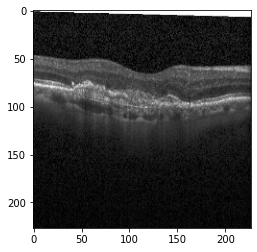

[[3.0646210e-29 3.7986280e-25 3.5796200e-25 0.0000000e+00 7.4095631e-05
  3.2016396e-07 7.8456805e-09 7.8975818e-06 6.2214822e-06 3.8743810e-08
  4.7320412e-07 6.3059824e-10 9.9867415e-01 4.0701109e-11 7.9851131e-10
  8.1116892e-04 4.2557842e-04]] tf.Tensor([12], shape=(1,), dtype=int64)


IndexError: list index out of range

In [51]:
file_name1="../input/kermany2018/OCT2017 /train/CNV/CNV-1016042-1.jpeg"
pred_and_plot(model,file_name1,class_names)